# Manual and Sklearn Ridge Regression Results Comparison

In [1]:
# Import necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score

In [2]:
# Directory where files are stored
DIRECTORY = 'hopkins_export/'  # Adjust this path as needed

In [3]:
class ManualRidgeRegression:
    def __init__(self, LAMBDA=1.0):
        # Initialize the Ridge Regression model with a regularization parameter lambda
        self.LAMBDA = LAMBDA  # Regularization parameter to control the penalty applied to the coefficients
        self.coef_ = None   # Placeholder for the model's coefficients
        self.intercept_ = None  # Placeholder for the intercept (bias term)

    def fit(self, X, y):
        # Add a bias term (column of ones) to X for calculating the intercept
        X_bias = np.c_[np.ones(X.shape[0]), X]  # Augment X with a column of ones for the intercept

        # Create an identity matrix for the regularization term, matching the dimensions of X_bias
        I = np.eye(X_bias.shape[1])
        I[0, 0] = 0  # Exclude the intercept from regularization by setting the first entry to 0

        # Compute the regularized matrix product: X.T * X + lambda * I
        # This is the closed-form solution for Ridge Regression
        XTX = X_bias.T @ X_bias + self.LAMBDA * I  # (X^T * X) + lambda * I for regularization

        # Compute the product of X.T and y, which is part of the closed-form solution
        XTy = X_bias.T @ y  # Calculate X^T * y

        # Solve for theta (coefficients), which includes both the intercept and the other coefficients
        theta = np.linalg.inv(XTX) @ XTy  # Solve for (X^T * X + lambda * I)^-1 * X^T * y

        # Separate the intercept and the coefficients from the theta vector
        self.intercept_ = theta[0]  # The first element is the intercept
        self.coef_ = theta[1:]      # The remaining elements are the coefficients for the features

    def predict(self, X):
        # Calculate predictions by applying the linear model to the input data X
        # The formula used here is y = X * coef_ + intercept
        return X @ self.coef_ + self.intercept_

    def score(self, X, y):
        # Calculate the R^2 score, which is a metric for model performance
        y_pred = self.predict(X)  # Generate predictions for the input data X
        ss_total = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares (variation in true values)
        ss_residual = np.sum((y - y_pred) ** 2)  # Residual sum of squares (errors in predictions)
        return 1 - (ss_residual / ss_total)  # R^2 score measures the proportion of explained variance

def manual_kfold_split(X, y, n_splits=5, seed=23):
    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Create an array of indices representing each data point in the dataset
    indices = np.arange(len(X))

    # Shuffle the indices to randomize the order of data points
    np.random.shuffle(indices)

    # Calculate the size of each fold, distributing any remaining points across the first folds
    fold_sizes = len(X) // n_splits * np.ones(n_splits, dtype=int)  # Initialize each fold size equally
    fold_sizes[:len(X) % n_splits] += 1  # Distribute remainder among the first few folds

    # Initialize a variable to keep track of the current index position in the shuffled indices
    current = 0

    # Initialize an empty list to store the indices of training and test sets for each fold
    splits = []

    # Loop over each fold size to create training and test indices for each split
    for fold_size in fold_sizes:
        # Define the start and stop indices for the test set of the current fold
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]  # Select test indices for the current fold

        # Define the training indices by excluding the test indices from the full set of indices
        train_indices = np.setdiff1d(indices, test_indices)  # Training set excludes current fold

        # Append the training and test indices as a tuple to the splits list
        splits.append((train_indices, test_indices))

        # Update the current index position for the next fold
        current = stop

    # Return the list of training and test indices for each fold
    return splits

In [4]:
# Set parameters for analysis
np.random.seed(23)
LAMBDAs = [0.001, 0.01, 0.1, 1, 10]  # Regularization strengths for Ridge
kf_splits = 5  # Number of K-Folds

# Initialize a dictionary to store the mean R^2 scores for each lambda across all subjects
manual_all_subject_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}

# Loop through all subject files in the specified directory
subject_files = [f for f in os.listdir(DIRECTORY) if f.endswith('.csv')]
for subject_file in subject_files:
    # Load each subject dataset
    subject_data = pd.read_csv(os.path.join(DIRECTORY, subject_file))
    
    # Dynamically determine sample sizes for the current subject based on its length
    sample_sizes = np.geomspace(1000, len(subject_data), num=3, dtype=int)

    # Calculate sample fractions for each subject
    sample_fractions = sample_sizes / len(subject_data)  # Adjusted per subject
    
    # Dictionary to hold mean R^2 scores for each lambda for the current subject
    manual_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}
    
    # Loop through each regularization strength (lambda)
    for LAMBDA in LAMBDAs:
        manual_LAMBDA_r2_scores = []  # List to collect R^2 scores for different sample sizes
        for sample_size in sample_sizes:
            # Randomly select a subset of the data for the given sample size
            np.random.seed(23)
            sample_indices = np.random.choice(len(subject_data), sample_size, replace=False)
            manual_X_sample = subject_data.drop(columns=["expected_time", "flip_time", "stim_pos", "user_pos", "lambda_val", "change_rate_x"]).iloc[sample_indices].values
            manual_y_pos_dif = (subject_data["user_pos"].iloc[sample_indices] - subject_data["stim_pos"].iloc[sample_indices]).values
            #manual_y_pos = (subject_data["stim_pos"].iloc[sample_indices]).values
            #manual_y_speed = (subject_data["change_rate_x"].iloc[sample_indices]).values

            manual_kf_r2_scores = []  # List to hold R^2 scores for each fold
            
            # Perform manual K-Fold splitting and scoring
            for train_idx, test_idx in manual_kfold_split(manual_X_sample, manual_y_pos_dif, n_splits=kf_splits, seed=23):
                model = ManualRidgeRegression(LAMBDA=LAMBDA)  # Initialize the Ridge model
                model.fit(manual_X_sample[train_idx], manual_y_pos_dif[train_idx])  # Fit the model on training data
                manual_kf_r2_scores.append(model.score(manual_X_sample[test_idx], manual_y_pos_dif[test_idx]))  # Evaluate on test data

            # Calculate the mean R^2 score for the current sample size and lambda
            manual_LAMBDA_r2_scores.append(np.mean(manual_kf_r2_scores))
        
        # Store mean R^2 scores for each lambda across all sample sizes for the current subject
        manual_mean_r2_scores[LAMBDA] = manual_LAMBDA_r2_scores

    # Append each subject's mean R^2 scores
    for LAMBDA in LAMBDAs:
        manual_all_subject_mean_r2_scores[LAMBDA].append(manual_mean_r2_scores[LAMBDA])

# Aggregate results by averaging across all subjects
posdif_manual_average_r2_scores = {LAMBDA: np.mean(manual_all_subject_mean_r2_scores[LAMBDA], axis=0) for LAMBDA in LAMBDAs}

# Initialize a dictionary to store the mean R^2 scores for each lambda across all subjects
manual_all_subject_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}

# Loop through all subject files in the specified directory
subject_files = [f for f in os.listdir(DIRECTORY) if f.endswith('.csv')]
for subject_file in subject_files:
    # Load each subject dataset
    subject_data = pd.read_csv(os.path.join(DIRECTORY, subject_file))
    
    # Dynamically determine sample sizes for the current subject based on its length
    sample_sizes = np.geomspace(1000, len(subject_data), num=3, dtype=int)

    # Calculate sample fractions for each subject
    sample_fractions = sample_sizes / len(subject_data)  # Adjusted per subject
    
    # Dictionary to hold mean R^2 scores for each lambda for the current subject
    manual_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}
    
    # Loop through each regularization strength (lambda)
    for LAMBDA in LAMBDAs:
        manual_LAMBDA_r2_scores = []  # List to collect R^2 scores for different sample sizes
        for sample_size in sample_sizes:
            # Randomly select a subset of the data for the given sample size
            np.random.seed(23)
            sample_indices = np.random.choice(len(subject_data), sample_size, replace=False)
            manual_X_sample = subject_data.drop(columns=["expected_time", "flip_time", "stim_pos", "user_pos", "lambda_val", "change_rate_x"]).iloc[sample_indices].values
            #manual_y_pos_dif = (subject_data["user_pos"].iloc[sample_indices] - subject_data["stim_pos"].iloc[sample_indices]).values
            manual_y_pos = (subject_data["stim_pos"].iloc[sample_indices]).values
            #manual_y_speed = (subject_data["change_rate_x"].iloc[sample_indices]).values

            manual_kf_r2_scores = []  # List to hold R^2 scores for each fold
            
            # Perform manual K-Fold splitting and scoring
            for train_idx, test_idx in manual_kfold_split(manual_X_sample, manual_y_pos, n_splits=kf_splits, seed=23):
                model = ManualRidgeRegression(LAMBDA=LAMBDA)  # Initialize the Ridge model
                model.fit(manual_X_sample[train_idx], manual_y_pos[train_idx])  # Fit the model on training data
                manual_kf_r2_scores.append(model.score(manual_X_sample[test_idx], manual_y_pos[test_idx]))  # Evaluate on test data

            # Calculate the mean R^2 score for the current sample size and lambda
            manual_LAMBDA_r2_scores.append(np.mean(manual_kf_r2_scores))
        
        # Store mean R^2 scores for each lambda across all sample sizes for the current subject
        manual_mean_r2_scores[LAMBDA] = manual_LAMBDA_r2_scores

    # Append each subject's mean R^2 scores
    for LAMBDA in LAMBDAs:
        manual_all_subject_mean_r2_scores[LAMBDA].append(manual_mean_r2_scores[LAMBDA])

# Aggregate results by averaging across all subjects
pos_manual_average_r2_scores = {LAMBDA: np.mean(manual_all_subject_mean_r2_scores[LAMBDA], axis=0) for LAMBDA in LAMBDAs}

# Initialize a dictionary to store the mean R^2 scores for each lambda across all subjects
manual_all_subject_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}

# Loop through all subject files in the specified directory
subject_files = [f for f in os.listdir(DIRECTORY) if f.endswith('.csv')]
for subject_file in subject_files:
    # Load each subject dataset
    subject_data = pd.read_csv(os.path.join(DIRECTORY, subject_file))
    
    # Dynamically determine sample sizes for the current subject based on its length
    sample_sizes = np.geomspace(1000, len(subject_data), num=3, dtype=int)

    # Calculate sample fractions for each subject
    sample_fractions = sample_sizes / len(subject_data)  # Adjusted per subject
    
    # Dictionary to hold mean R^2 scores for each lambda for the current subject
    manual_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}
    
    # Loop through each regularization strength (lambda)
    for LAMBDA in LAMBDAs:
        manual_LAMBDA_r2_scores = []  # List to collect R^2 scores for different sample sizes
        for sample_size in sample_sizes:
            # Randomly select a subset of the data for the given sample size
            np.random.seed(23)
            sample_indices = np.random.choice(len(subject_data), sample_size, replace=False)
            manual_X_sample = subject_data.drop(columns=["expected_time", "flip_time", "stim_pos", "user_pos", "lambda_val", "change_rate_x"]).iloc[sample_indices].values
            #manual_y_pos_dif = (subject_data["user_pos"].iloc[sample_indices] - subject_data["stim_pos"].iloc[sample_indices]).values
            #manual_y_pos = (subject_data["stim_pos"].iloc[sample_indices]).values
            manual_y_speed = (subject_data["change_rate_x"].iloc[sample_indices]).values

            manual_kf_r2_scores = []  # List to hold R^2 scores for each fold
            
            # Perform manual K-Fold splitting and scoring
            for train_idx, test_idx in manual_kfold_split(manual_X_sample, manual_y_speed, n_splits=kf_splits, seed=23):
                model = ManualRidgeRegression(LAMBDA=LAMBDA)  # Initialize the Ridge model
                model.fit(manual_X_sample[train_idx], manual_y_speed[train_idx])  # Fit the model on training data
                manual_kf_r2_scores.append(model.score(manual_X_sample[test_idx], manual_y_speed[test_idx]))  # Evaluate on test data

            # Calculate the mean R^2 score for the current sample size and lambda
            manual_LAMBDA_r2_scores.append(np.mean(manual_kf_r2_scores))
        
        # Store mean R^2 scores for each lambda across all sample sizes for the current subject
        manual_mean_r2_scores[LAMBDA] = manual_LAMBDA_r2_scores

    # Append each subject's mean R^2 scores
    for LAMBDA in LAMBDAs:
        manual_all_subject_mean_r2_scores[LAMBDA].append(manual_mean_r2_scores[LAMBDA])

# Aggregate results by averaging across all subjects
speed_manual_average_r2_scores = {LAMBDA: np.mean(manual_all_subject_mean_r2_scores[LAMBDA], axis=0) for LAMBDA in LAMBDAs}

In [5]:
sklearn_all_subject_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}

subject_files = [f for f in os.listdir(DIRECTORY) if f.endswith('.csv')]
for subject_file in subject_files:
    # Load each subject dataset
    subject_data = pd.read_csv(os.path.join(DIRECTORY, subject_file))
    
    # Dynamically determine sample sizes for the current subject based on its length
    sample_sizes = np.geomspace(1000, len(subject_data), num=3, dtype=int)

    # Calculate sample fractions for each subject
    sample_fractions = sample_sizes / len(subject_data)  # Adjusted per subject
    
    # Dictionary to hold mean R^2 scores for each lambda for the current subject
    sklearn_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}
    
    # Loop through each regularization strength (lambda)
    for LAMBDA in LAMBDAs:
        LAMBDA_r2_scores = []  # List to collect R^2 scores for different sample sizes
        for sample_size in sample_sizes:
            # Randomly select a subset of the data for the given sample size
            np.random.seed(23)
            sample_indices = np.random.choice(len(subject_data), sample_size, replace=False)
            X_sample = subject_data.drop(columns=["expected_time", "flip_time", "stim_pos", "user_pos", "lambda_val", "change_rate_x"]).iloc[sample_indices].values
            y_pos_dif = (subject_data["user_pos"].iloc[sample_indices] - subject_data["stim_pos"].iloc[sample_indices]).values
            #y_pos = (subject_data["stim_pos"].iloc[sample_indices]).values
            #y_speed = (subject_data["change_rate_x"].iloc[sample_indices]).values

            # Initialize Ridge model with the specified LAMBDA (alpha)
            ridge_model = Ridge(alpha=LAMBDA)
            
            # Perform K-Fold cross-validation
            kf = KFold(n_splits=kf_splits, shuffle=True, random_state=23)
            kf_r2_scores = [ridge_model.fit(X_sample[train_idx], y_pos_dif[train_idx]).score(X_sample[test_idx], y_pos_dif[test_idx])
                            for train_idx, test_idx in kf.split(X_sample)]

            # Calculate the mean R^2 score for the current sample size and lambda
            LAMBDA_r2_scores.append(np.mean(kf_r2_scores))
        
        # Store mean R^2 scores for each lambda across all sample sizes for the current subject
        sklearn_mean_r2_scores[LAMBDA] = LAMBDA_r2_scores

    # Append each subject's mean R^2 scores
    for LAMBDA in LAMBDAs:
        sklearn_all_subject_mean_r2_scores[LAMBDA].append(sklearn_mean_r2_scores[LAMBDA])

posdif_sklearn_average_r2_scores = {LAMBDA: np.mean(sklearn_all_subject_mean_r2_scores[LAMBDA], axis=0) for LAMBDA in LAMBDAs}

sklearn_all_subject_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}

subject_files = [f for f in os.listdir(DIRECTORY) if f.endswith('.csv')]
for subject_file in subject_files:
    # Load each subject dataset
    subject_data = pd.read_csv(os.path.join(DIRECTORY, subject_file))
    
    # Dynamically determine sample sizes for the current subject based on its length
    sample_sizes = np.geomspace(1000, len(subject_data), num=3, dtype=int)

    # Calculate sample fractions for each subject
    sample_fractions = sample_sizes / len(subject_data)  # Adjusted per subject
    
    # Dictionary to hold mean R^2 scores for each lambda for the current subject
    sklearn_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}
    
    # Loop through each regularization strength (lambda)
    for LAMBDA in LAMBDAs:
        LAMBDA_r2_scores = []  # List to collect R^2 scores for different sample sizes
        for sample_size in sample_sizes:
            # Randomly select a subset of the data for the given sample size
            np.random.seed(23)
            sample_indices = np.random.choice(len(subject_data), sample_size, replace=False)
            X_sample = subject_data.drop(columns=["expected_time", "flip_time", "stim_pos", "user_pos", "lambda_val", "change_rate_x"]).iloc[sample_indices].values
            #y_pos_dif = (subject_data["user_pos"].iloc[sample_indices] - subject_data["stim_pos"].iloc[sample_indices]).values
            #y_pos = (subject_data["stim_pos"].iloc[sample_indices]).values
            y_speed = (subject_data["change_rate_x"].iloc[sample_indices]).values

            # Initialize Ridge model with the specified LAMBDA (alpha)
            ridge_model = Ridge(alpha=LAMBDA)
            
            # Perform K-Fold cross-validation
            kf = KFold(n_splits=kf_splits, shuffle=True, random_state=23)
            kf_r2_scores = [ridge_model.fit(X_sample[train_idx], y_speed[train_idx]).score(X_sample[test_idx], y_speed[test_idx])
                            for train_idx, test_idx in kf.split(X_sample)]

            # Calculate the mean R^2 score for the current sample size and lambda
            LAMBDA_r2_scores.append(np.mean(kf_r2_scores))
        
        # Store mean R^2 scores for each lambda across all sample sizes for the current subject
        sklearn_mean_r2_scores[LAMBDA] = LAMBDA_r2_scores

    # Append each subject's mean R^2 scores
    for LAMBDA in LAMBDAs:
        sklearn_all_subject_mean_r2_scores[LAMBDA].append(sklearn_mean_r2_scores[LAMBDA])

speed_sklearn_average_r2_scores = {LAMBDA: np.mean(sklearn_all_subject_mean_r2_scores[LAMBDA], axis=0) for LAMBDA in LAMBDAs}

sklearn_all_subject_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}

subject_files = [f for f in os.listdir(DIRECTORY) if f.endswith('.csv')]
for subject_file in subject_files:
    # Load each subject dataset
    subject_data = pd.read_csv(os.path.join(DIRECTORY, subject_file))
    
    # Dynamically determine sample sizes for the current subject based on its length
    sample_sizes = np.geomspace(1000, len(subject_data), num=3, dtype=int)

    # Calculate sample fractions for each subject
    sample_fractions = sample_sizes / len(subject_data)  # Adjusted per subject
    
    # Dictionary to hold mean R^2 scores for each lambda for the current subject
    sklearn_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}
    
    # Loop through each regularization strength (lambda)
    for LAMBDA in LAMBDAs:
        LAMBDA_r2_scores = []  # List to collect R^2 scores for different sample sizes
        for sample_size in sample_sizes:
            # Randomly select a subset of the data for the given sample size
            np.random.seed(23)
            sample_indices = np.random.choice(len(subject_data), sample_size, replace=False)
            X_sample = subject_data.drop(columns=["expected_time", "flip_time", "stim_pos", "user_pos", "lambda_val", "change_rate_x"]).iloc[sample_indices].values
            #y_pos_dif = (subject_data["user_pos"].iloc[sample_indices] - subject_data["stim_pos"].iloc[sample_indices]).values
            y_pos = (subject_data["stim_pos"].iloc[sample_indices]).values
            #y_speed = (subject_data["change_rate_x"].iloc[sample_indices]).values

            # Initialize Ridge model with the specified LAMBDA (alpha)
            ridge_model = Ridge(alpha=LAMBDA)
            
            # Perform K-Fold cross-validation
            kf = KFold(n_splits=kf_splits, shuffle=True, random_state=23)
            kf_r2_scores = [ridge_model.fit(X_sample[train_idx], y_pos[train_idx]).score(X_sample[test_idx], y_pos[test_idx])
                            for train_idx, test_idx in kf.split(X_sample)]

            # Calculate the mean R^2 score for the current sample size and lambda
            LAMBDA_r2_scores.append(np.mean(kf_r2_scores))
        
        # Store mean R^2 scores for each lambda across all sample sizes for the current subject
        sklearn_mean_r2_scores[LAMBDA] = LAMBDA_r2_scores

    # Append each subject's mean R^2 scores
    for LAMBDA in LAMBDAs:
        sklearn_all_subject_mean_r2_scores[LAMBDA].append(sklearn_mean_r2_scores[LAMBDA])

pos_sklearn_average_r2_scores = {LAMBDA: np.mean(sklearn_all_subject_mean_r2_scores[LAMBDA], axis=0) for LAMBDA in LAMBDAs}

c:\Users\ishad\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.40657e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\ishad\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.55825e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\ishad\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.22247e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\ishad\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.20839e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\ishad\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:20

In [8]:
manual_posdif = pd.DataFrame(posdif_manual_average_r2_scores)
manual_pos = pd.DataFrame(pos_manual_average_r2_scores)
manual_speed = pd.DataFrame(speed_manual_average_r2_scores)
sklearn_posdif = pd.DataFrame(posdif_sklearn_average_r2_scores)
sklearn_pos = pd.DataFrame(pos_sklearn_average_r2_scores)
sklearn_speed = pd.DataFrame(speed_sklearn_average_r2_scores)

manual_posdif

,0.001,0.010,0.100,1.000,10.000
0,-0.018068,-0.012206,-0.007256,-0.004786,-0.005359
1,0.033199,0.033432,0.032294,0.026266,0.018411
2,0.039447,0.039456,0.039006,0.035113,0.026649


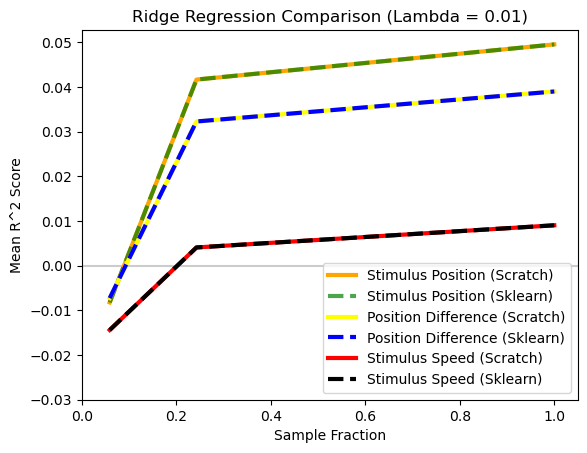

In [35]:
fractions = [0.058823, 0.24252, 1]

plt.hlines(0, 0, 1.05, color = 'black', alpha = 0.2)

plt.plot(fractions, manual_pos.iloc[:,2], color = 'orange', linewidth = 3, label = 'Stimulus Position (Scratch)')
plt.plot(fractions, sklearn_pos.iloc[:,2], color = 'green', linestyle = '--', linewidth = 3, alpha = 0.7, label = 'Stimulus Position (Sklearn)')

plt.plot(fractions, manual_posdif.iloc[:,2], color = 'yellow', linewidth = 3, label = 'Position Difference (Scratch)')
plt.plot(fractions, sklearn_posdif.iloc[:,2], color = 'blue', linestyle = '--', linewidth = 3, label = 'Position Difference (Sklearn)')

plt.plot(fractions, manual_speed.iloc[:,2], color = 'red', linewidth = 3, label = 'Stimulus Speed (Scratch)')
plt.plot(fractions, sklearn_speed.iloc[:,2], color = 'black', linestyle = '--', linewidth = 3, label = 'Stimulus Speed (Sklearn)')

plt.title('Ridge Regression Comparison (Lambda = 0.01)')
plt.legend()
plt.xlabel('Sample Fraction')
plt.ylabel('Mean R^2 Score')
plt.xlim(0,1.05)
plt.ylim(-0.03,None)
plt.show()